In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle


In [3]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates = True)
df.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                       
2025-04-01 21:15:00   1  34.3262      33.3125         3262.0        84   
2025-04-01 21:30:00   2  33.9057      33.4688         3232.5        84   
2025-04-01 21:45:00   3  33.2979      33.5938         3218.0        85   
2025-04-01 22:00:00   4  33.6201      33.3281         3211.0        85   
2025-04-01 22:15:00   5  33.2979      33.3438         3203.0        85   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-01 21:15:00      27.9            0.1          100  
2025-04-01 21:30:00      27.8            0.1          100  
2025-04-01 21:45:00      27.8            0.1          100  
2025-04-01 22:00:00      27.6            0.0          100  
2025-04-01 22:15:00      27.6            0.0          100

In [4]:
df = df.resample('D').mean()
df.head()

id       light  temperature  soil_moisture   humidity  \
ts                                                                     
2025-04-01    6.0   30.485055    33.485800    3211.045455  83.909091   
2025-04-02   46.0   27.144790    33.753629    3158.710145  62.623188   
2025-04-03  128.5   25.908357    33.485352    3121.473958  76.322917   
2025-04-04  224.5   25.931506    33.122399    3223.473958  72.354167   
2025-04-05  320.0  141.128589    33.805593    3099.052632  71.084211   

             api_temp  precipitation  cloud_cover  
ts                                                 
2025-04-01  28.200000       0.027273    96.363636  
2025-04-02  31.623188       0.000000    87.246377  
2025-04-03  29.742708       0.025000    81.854167  
2025-04-04  30.153125       0.000000    36.416667  
2025-04-05  30.283158       0.000000    63.873684

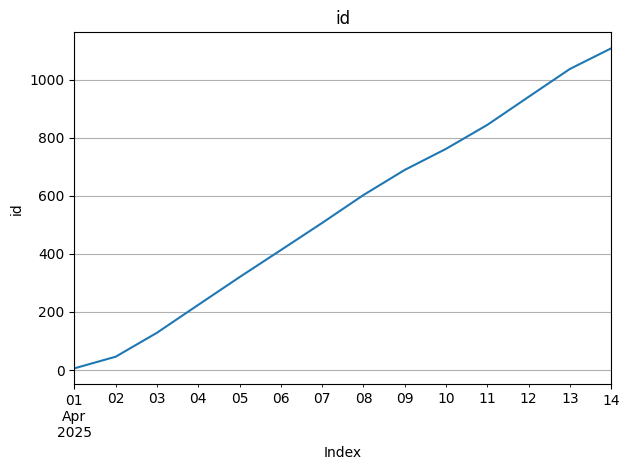

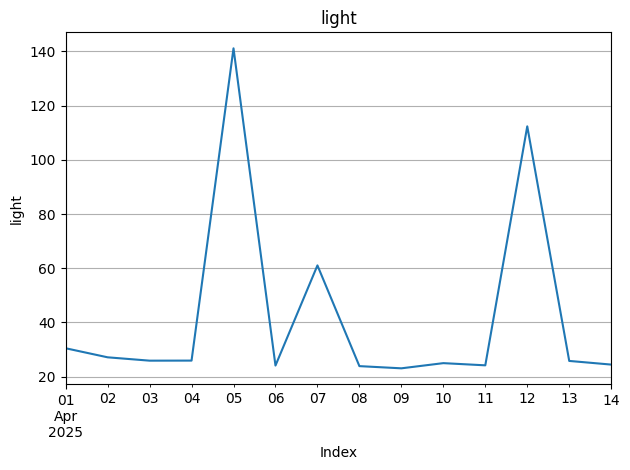

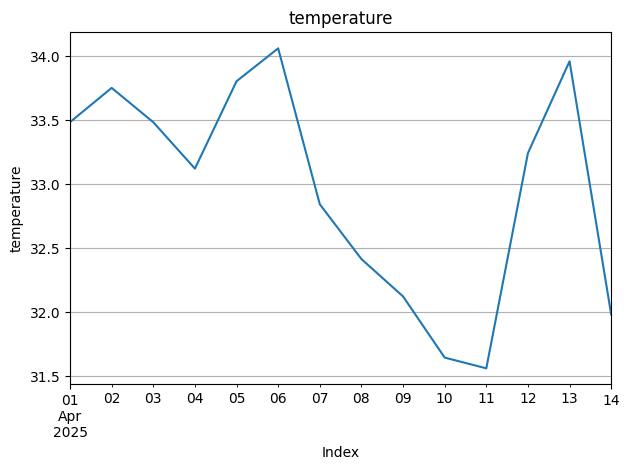

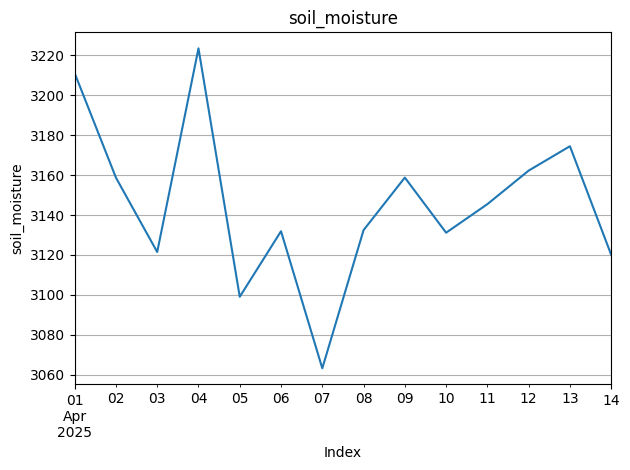

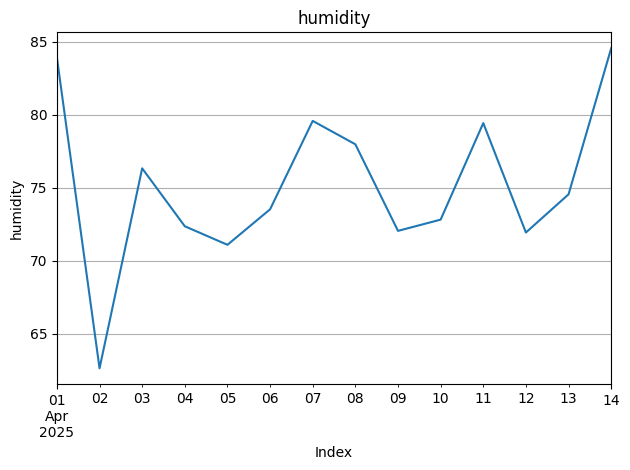

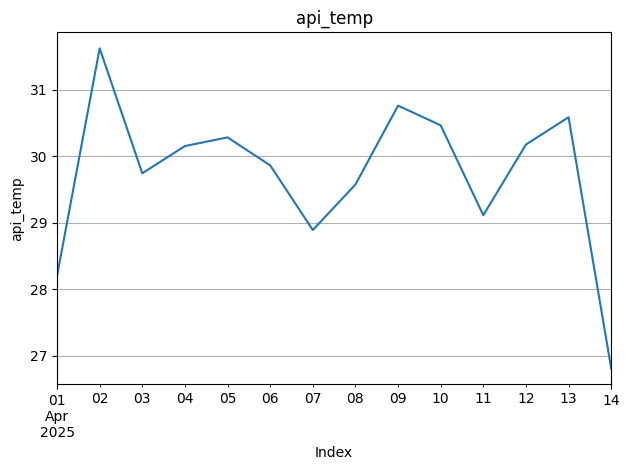

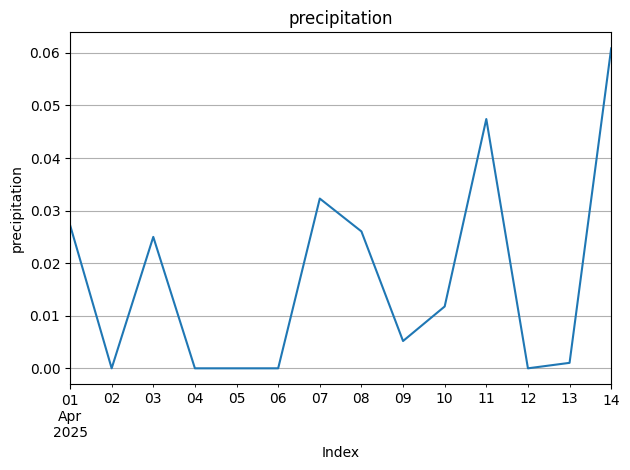

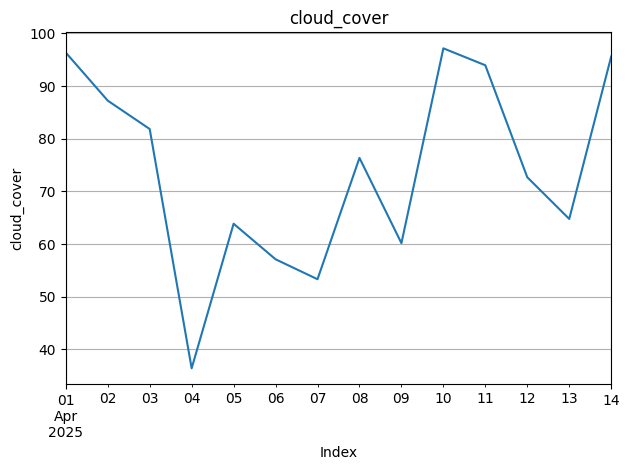

In [5]:
for column in df.columns:
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

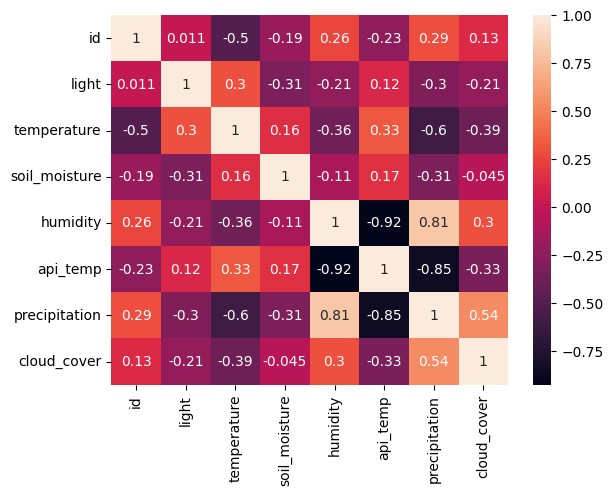

In [6]:
sns.heatmap(df.corr(),annot=True)

# EDA

In [7]:
df["soil_moisture"].diff().dropna()

ts
2025-04-02    -52.335310
2025-04-03    -37.236187
2025-04-04    102.000000
2025-04-05   -124.421327
2025-04-06     32.826489
2025-04-07    -68.651725
2025-04-08     69.215312
2025-04-09     26.310538
2025-04-10    -27.613541
2025-04-11     14.303593
2025-04-12     16.791076
2025-04-13     12.218750
2025-04-14    -54.355299
Freq: D, Name: soil_moisture, dtype: float64

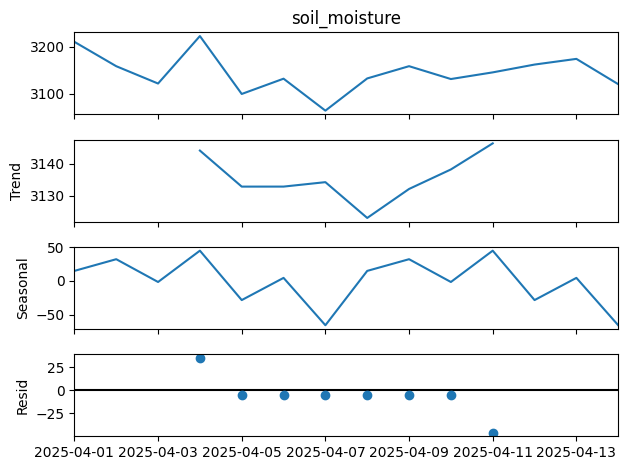

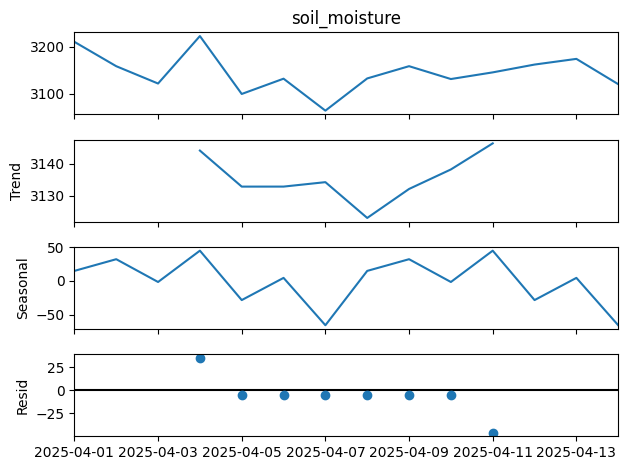

In [8]:
seasonal_decompose(df["soil_moisture"], model="additive").plot()


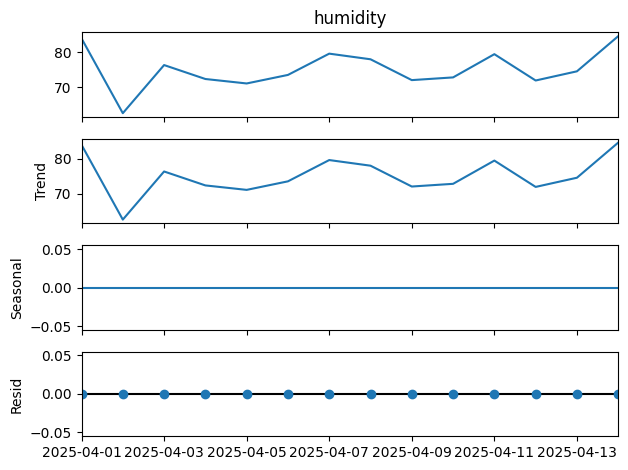

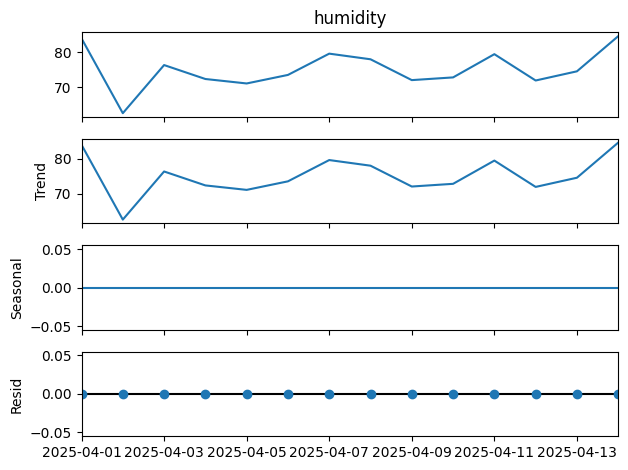

In [9]:
seasonal_decompose(df["humidity"], model="additive", period=1).plot()

## Find D parameter

In [10]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -8.718835440467966
p-value: 3.429297974474895e-14
Critial Values:
   1%, -4.6651863281249994
Critial Values:
   5%, -3.3671868750000002
Critial Values:
   10%, -2.802960625


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

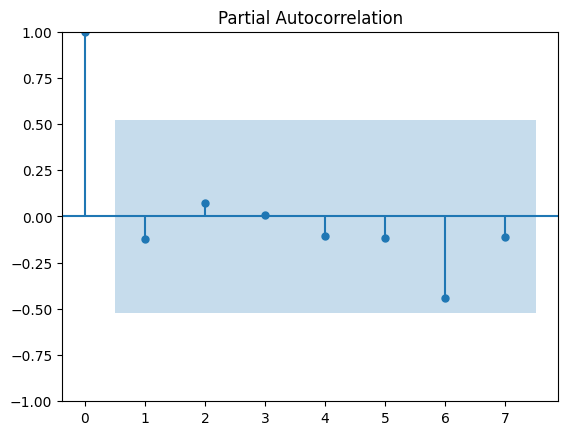

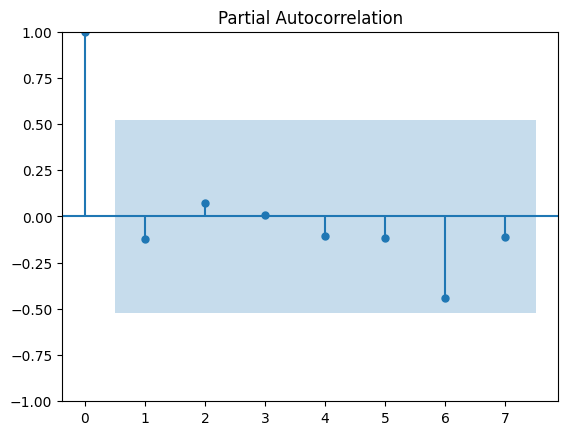

In [ ]:
plot_pacf(df["soil_moisture"])


There are 1 exceptionally high bars, therefore, p=1

## Find Q parameter

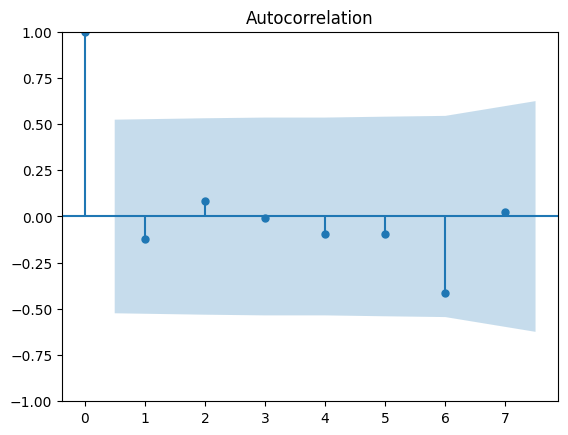

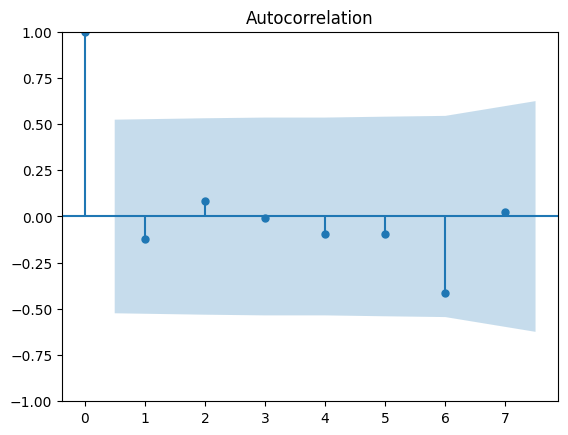

In [12]:
plot_acf(df["soil_moisture"])

There are 1 exceptionally high bars, therefore, q=1

## Separate the test and train data

In [13]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]

In [14]:
train_data.head()

id       light  temperature  soil_moisture   humidity  \
ts                                                                     
2025-04-01    6.0   30.485055    33.485800    3211.045455  83.909091   
2025-04-02   46.0   27.144790    33.753629    3158.710145  62.623188   
2025-04-03  128.5   25.908357    33.485352    3121.473958  76.322917   
2025-04-04  224.5   25.931506    33.122399    3223.473958  72.354167   
2025-04-05  320.0  141.128589    33.805593    3099.052632  71.084211   

             api_temp  precipitation  cloud_cover  
ts                                                 
2025-04-01  28.200000       0.027273    96.363636  
2025-04-02  31.623188       0.000000    87.246377  
2025-04-03  29.742708       0.025000    81.854167  
2025-04-04  30.153125       0.000000    36.416667  
2025-04-05  30.283158       0.000000    63.873684

In [15]:
test_data.head()

id      light  temperature  soil_moisture   humidity  \
ts                                                                    
2025-04-09  689.0  23.082801    32.123174    3158.753247  72.038961   
2025-04-10  761.5  24.993522    31.644756    3131.139706  72.808824   
2025-04-11  844.0  24.186542    31.560729    3145.443299  79.422680   

             api_temp  precipitation  cloud_cover  
ts                                                 
2025-04-09  30.761039       0.005195    60.181818  
2025-04-10  30.464706       0.011765    97.176471  
2025-04-11  29.112371       0.047423    93.958763

In [16]:
train_data[["soil_moisture"]]

soil_moisture
ts                       
2025-04-01    3211.045455
2025-04-02    3158.710145
2025-04-03    3121.473958
2025-04-04    3223.473958
2025-04-05    3099.052632
2025-04-06    3131.879121
2025-04-07    3063.227396
2025-04-08    3132.442708
2025-04-09    3158.753247

wtf?

In [17]:
test_data['soil_moisture'].count()



3

## Train the model

In [34]:
test_data[['temperature','humidity','api_temp']]

temperature   humidity   api_temp
ts                                           
2025-04-09    32.123174  72.038961  30.761039
2025-04-10    31.644756  72.808824  30.464706
2025-04-11    31.560729  79.422680  29.112371

In [18]:
model = SARIMAX(
    endog=test_data['soil_moisture'],
    exog=test_data[['temperature','humidity','api_temp']],  # Use DataFrame/Series, not column name
    order=(2,0,0)
)
results = model.fit()
results.summary()

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                    3
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  31.782
Date:                Sun, 27 Apr 2025   AIC                            -51.564
Time:                        11:15:15   BIC                            -56.972
Sample:                    04-09-2025   HQIC                           -62.435
                         - 04-11-2025                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    54.6795   2.19e-19   2.49e+20      0.000      54.679      54.679
humidity        8.2350   4.98e-19   1.65e+19      0.000       8.235       8.235
api_temp       26.3005    2.1e-19   1.25e+20      0.000      26.301      26.301
ar.L1               -0   1.56e-33         -0      1.000   -3.06e-33    3.06e-33
ar.L2                0   4.92e-26          0      1.000   -9.64e-26    9.64e-26
sigma2           1e-10   1.14e-09      0.087      0.930   -2.14e-09    2.34e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.65   Prob(JB):                         0.77
Heteroskedasticity (H):                nan   Skew:                             0.71
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.07e+49. Standard errors may be unstable.
"""

In [19]:
help(results)

Help on SARIMAXResultsWrapper in module statsmodels.tsa.statespace.sarimax:

<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object>
    Class to hold results from fitting an SARIMAX model.

    Parameters
    ----------
    model : SARIMAX instance
        The fitted model instance

    Attributes
    ----------
    specification : dictionary
        Dictionary including all attributes from the SARIMAX model instance.
    polynomial_ar : ndarray
        Array containing autoregressive lag polynomial coefficients,
        ordered from lowest degree to highest. Initialized with ones, unless
        a coefficient is constrained to be zero (in which case it is zero).
    polynomial_ma : ndarray
        Array containing moving average lag polynomial coefficients,
        ordered from lowest degree to highest. Initialized with ones, unless
        a coefficient is constrained to be zero (in which case it is zero).
    polynomial_seasonal_ar : ndarray
        Array containing seaso

Import the model to predict the exog values

In [26]:
# Import exog data predicting models 
with open('../exports/api_temp_sarima.pkl', 'rb') as file:
    api_temp_model = pickle.load(file)

with open('../exports/humidity_sarima.pkl', 'rb') as file:
    humidity_model = pickle.load(file)

with open('../exports/temperature_sarima.pkl', 'rb') as file:
    temperature_model = pickle.load(file)

In [28]:
api_temp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          api_temp   No. Observations:                    9
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 3)   Log Likelihood                 -17.040
Date:                           Sun, 27 Apr 2025   AIC                             44.081
Time:                                   11:24:47   BIC                             45.067
Sample:                               04-01-2025   HQIC                            41.953
                                    - 04-09-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.404      2.475      0.013       0.208       1.792
ma.L1         -0.9932     22.968     -0.043      0.966     -46.010      44.024
ar.S.L3        0.9998      3.425      0.292      0.770      -5.712       7.712
ma.S.L3       -0.9873     89.828     -0.011      0.991    -177.047     175.072
sigma2         0.8065     64.503      0.013      0.990    -125.616     127.229
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.62   Prob(JB):                         0.62
Heteroskedasticity (H):               0.31   Skew:                             0.79
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
help(api_temp_model.get_forecast)

Help on method get_forecast in module statsmodels.tsa.statespace.mlemodel:

get_forecast(steps=1, signal_only=False, **kwargs) method of statsmodels.tsa.statespace.sarimax.SARIMAXResults instance
    Out-of-sample forecasts and prediction intervals

    Parameters
    ----------
    steps : int, str, or datetime, optional
        If an integer, the number of steps to forecast from the end of the
        sample. Can also be a date string to parse or a datetime type.
        However, if the dates index does not have a fixed frequency, steps
        must be an integer. Default is 1.
    signal_only : bool, optional
        Whether to compute forecasts of only the "signal" component of
        the observation equation. Default is False. For example, the
        observation equation of a time-invariant model is
        :math:`y_t = d + Z \alpha_t + \varepsilon_t`, and the "signal"
        component is then :math:`Z \alpha_t`. If this argument is set to
        True, then forecasts of the "s

In [44]:
# Predicting the data
exog_predictions = None
forecast_steps = len(test_data)

forecast_index = pd.date_range(
            start=test_data.index[0],
            freq=timedelta(days=1),
            periods=int(test_data['api_temp'].count()),
        )
print(test_data['soil_moisture'].count())
exog_predictions = api_temp_model.get_forecast(steps=forecast_steps).predicted_mean
exog_predictions.columns = ["api_temp"]

humidity_predictions = humidity_model.get_forecast(steps=forecast_steps).predicted_mean
humidity_predictions.columns = ["humidity"]

temperature_predictions = temperature_model.get_forecast(steps=forecast_steps).predicted_mean
temperature_predictions.columns = ["temperature"]

exog_predictions = pd.concat(
                    [exog_predictions, humidity_predictions], axis=1
                )
exog_predictions = pd.concat(
                    [exog_predictions, temperature_predictions], axis=1
                )

exog_predictions.head()

3


predicted_mean  predicted_mean  predicted_mean
2025-04-10       29.483556       75.730149       31.581573
2025-04-11       30.195454       73.066127       31.864308
2025-04-12       30.008515       74.190362       31.934744

In [39]:
prediction = results.get_forecast(steps = int(test_data['soil_moisture'].count()), exog=exog_predictions).predicted_mean
prediction.columns = ['predicted']
prediction

2025-04-12    3066.397782
2025-04-13    3090.821816
2025-04-14    3091.710706
Freq: D, Name: predicted_mean, dtype: float64

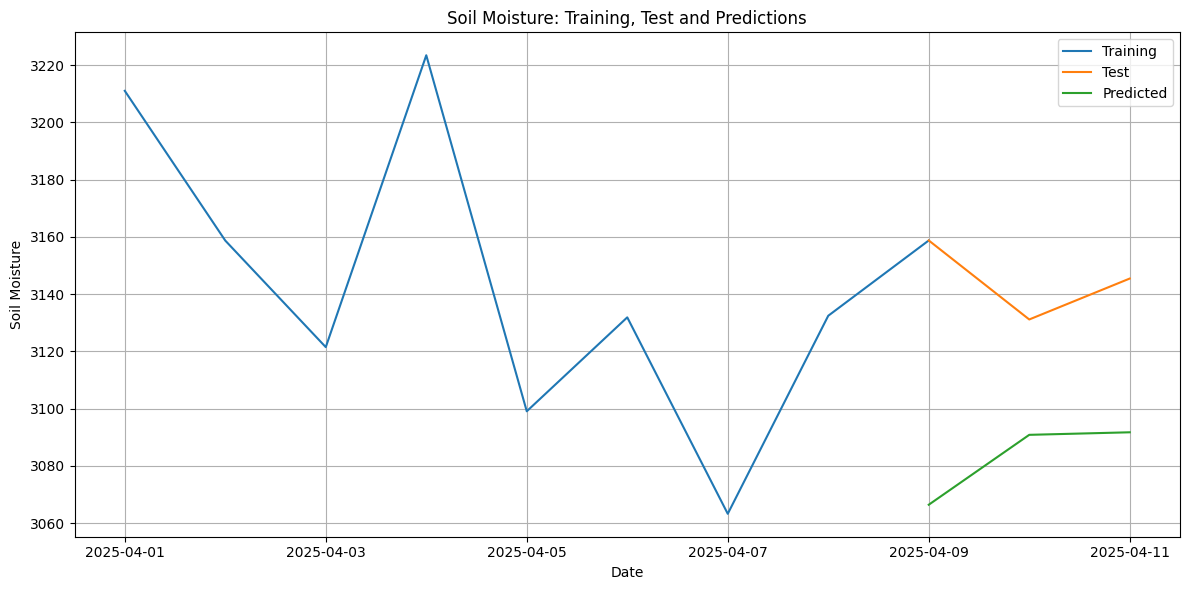

RMSE :  65.93495709347752


In [42]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


## Exporting the trained model with Pickle for external uses.

**Warning** : Do not unpickle untrusted model because it might execute a malicious code hidden in the model file.

In [43]:
with open('../exports/plant_water.pkl', 'wb') as file:
    pickle.dump(results, file)